In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

load_dotenv()
openai=OpenAI()

MODEL="gpt-4o-mini"

In [2]:
system_msg="You are flight assitant of AI Flight Company which books air tickets online. You help customer to book with air tickets\
.Be accurate, if you don't know, then say so. Please answer gently in consice manner in 1 sentence"

def chat(input, history):
    history.append({"role":"user","content":input})
    history.append({"role":"system","content":system_msg})
    r=openai.chat.completions.create(model=MODEL,messages=history)
    return r.choices[0].message.content

In [3]:
gr.ChatInterface(fn=chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [4]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [5]:
get_ticket_price("Delhi")

Tool get_ticket_price called for Delhi


'Unknown'

In [6]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [7]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

In [8]:
# Below is response from OpenAI
# choices=[Choice(
#     finish_reason='tool_calls', 
#     index=0, 
#     logprobs=None, 
#     message=chat.completionsMessage(
#         content=None, 
#         role='assistant', 
#         function_call=None, 
#         tool_calls=[
#             chat.completionsMessageToolCall(
#                 id='call_62136354', 
#                 function=Function(
#                     arguments='{"order_id":"order_12345"}', 
#                     name='get_delivery_date'), 
#                 type='function')
#         ])
# )]

# Refer https://platform.openai.com/docs/guides/function-calling
import json
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    if tool_call.function.name == 'get_ticket_price':
        price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": message.tool_calls[0].id
    }
    return response,city
def chat(message,history):
    history.append({"role":"user","content":message})
    history.append({"role":"system","content":system_msg})
    response=openai.chat.completions.create(model=MODEL,messages=history,tools=tools)
    print(response)
    if response.choices[0].finish_reason=="tool_calls":
        message=response.choices[0].message
        response, city = handle_tool_call(message)
        history.append(message)
        history.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=history)
    return response.choices[0].message.content
    

In [9]:
gr.ChatInterface(fn=chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [10]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [11]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

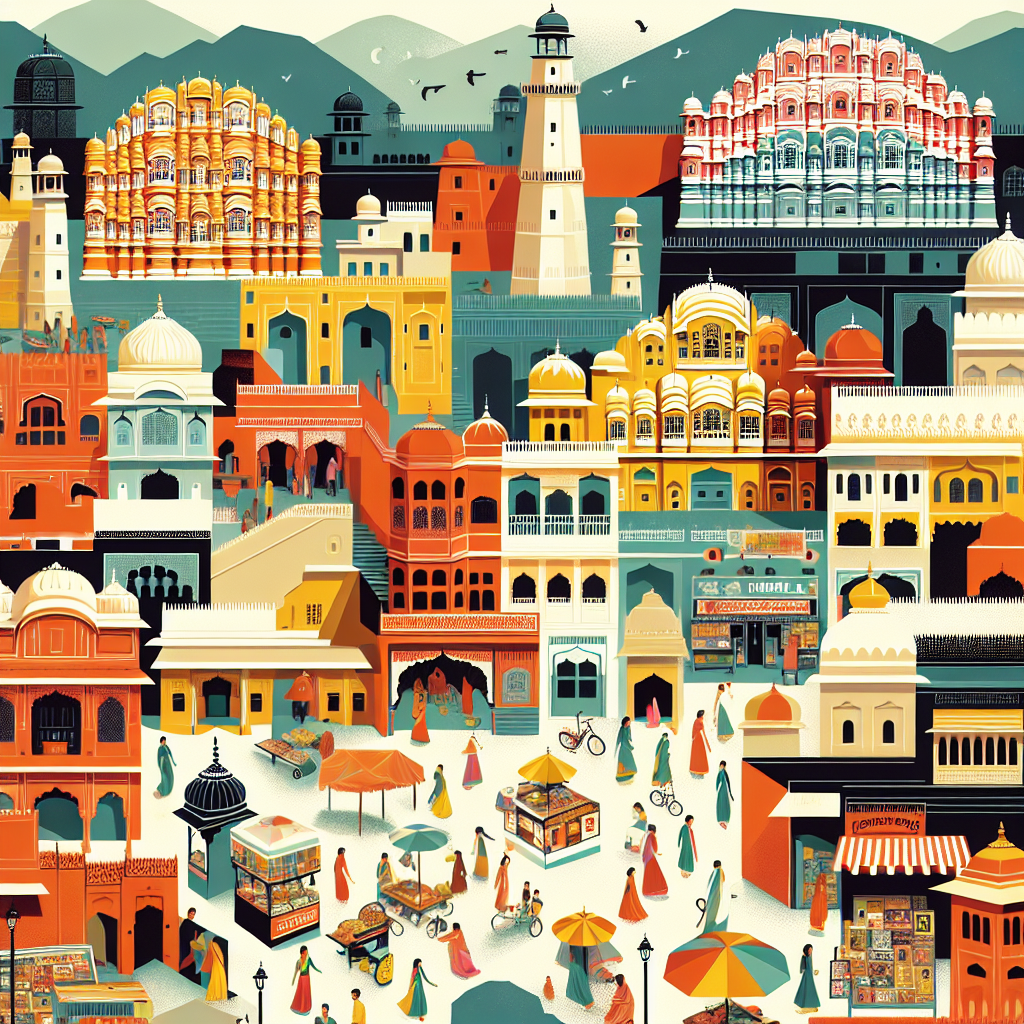

In [29]:
# image = artist("Jaipur")
# display(image)

In [12]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [32]:
talker("Well, hi there")

Input #0, wav, from '/tmp/tmp9gd4xjlp.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:00.82, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Let’s dive deeper into the specific line of code you mentioned, which involves submitting a message and handling the subsequent processing in the Gradio interface:

### Code Breakdown

```python
msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
    bot, chatbot, [chatbot, image_output]
)
```

### Understanding `msg.submit`

1. **Event Trigger**:
   - `msg.submit(...)` sets up an event listener for the `Textbox` component (`msg`). This listener triggers when the user submits their input (typically by pressing Enter).

2. **Parameters**:
   - The `submit` method takes several arguments:
     - **Function to Call**: 
       - `user`: This is the function that will be called when the user submits a message.
     - **Inputs**:
       - `[msg, chatbot]`: This specifies the inputs for the `user` function:
         - `msg`: The current value of the `Textbox`, representing the user's message.
         - `chatbot`: The current state of the chatbot display.
     - **Outputs**:
       - `[msg, chatbot]`: This specifies where the outputs from the `user` function will be sent:
         - The first `msg` is for updating the input textbox (which will be cleared).
         - The second `chatbot` is for updating the chatbot display with the new message from the user.
     - **Queue Parameter**:
       - `queue=False`: This indicates that the event should not be queued, meaning it will execute immediately without waiting for other events to complete.

### What Happens in the `user` Function

When a user submits a message, the `user` function is called with the current message and the chatbot's history:

```python
def user(user_message, history):
    return "", history + [[user_message, None]]
```

- **Parameters**:
  - `user_message`: The message entered by the user.
  - `history`: The current chat history (a list of previous messages).
- **Return Values**:
  - `return "", history + [[user_message, None]]`: 
    - The first part (`""`) clears the `Textbox` after submission.
    - The second part updates the `history` by appending the new user message along with a placeholder for the bot's response (set to `None` initially).

### Chaining with `.then()`

The `.then(...)` method is used to chain another action that should happen after the `user` function completes:

```python
.then(bot, chatbot, [chatbot, image_output])
```

1. **Function to Call**:
   - `bot`: This is the next function to be called after the `user` function completes.

2. **Inputs for the `bot` Function**:
   - `chatbot`: This is the updated chatbot history (now including the new user message).

3. **Outputs for the `bot` Function**:
   - `[chatbot, image_output]`: 
     - The first element (`chatbot`) will update the chatbot display with the new conversation history, which now includes the bot's response.
     - The second element (`image_output`) will display any image returned by the `bot` function.

### Inside the `bot` Function

The `bot` function processes the user's message and generates a response:

```python
def bot(history):
    user_message = history[-1][0]  # Get the last user message
    bot_message, image = chat(user_message, history[:-1])  # Get response from the chat function
    history[-1][1] = bot_message  # Update history with bot's response
    return history, image  # Return updated history and any image
```

- **Functionality**:
  - It retrieves the last user message from the `history`, calls a function (presumably `chat`) to get the bot's response, and updates the history with the bot's message.
  - Finally, it returns the updated history and any image generated by the bot.

### Summary

In summary, the `msg.submit(...)` line sets up an event-driven interaction where:
- A user submits a message via a textbox.
- The `user` function processes this message, updating the chat history and clearing the input field.
- The `.then(...)` method chains the processing to the `bot` function, which generates a response and updates the chatbot display and any associated image output.

This structure allows for a smooth and interactive user experience, enabling real-time conversation with the AI assistant.

In [24]:
def chat(msg,history):
    image=None
    conversation=[{"role":"system","content":system_msg}]
    for human,assistant in history:
        conversation.append({"role": "user", "content": human})
        conversation.append({"role": "assistant", "content": assistant})
    conversation.append({"role": "user", "content": msg})
    response = openai.chat.completions.create(model=MODEL, messages=conversation, tools=tools)
    if response.choices[0].finish_reason=="tool_calls":
        message = tool_call = response.choices[0].message
        response, city = handle_tool_call(message)
        conversation.append(message)
        conversation.append(response)
        # image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=conversation)

    reply = response.choices[0].message.content
    talker(reply)
    return reply, image
        
with gr.Blocks() as ui:
    with gr.Row():
        chatbot=gr.Chatbot(height=500)
        image_op=gr.Image(height=500)
    with gr.Row():
        msg=gr.Textbox(label="Chat with AI")
    with gr.Row():
        clear=gr.Button("Clear")
    def user(msg,history):
        return "", history + [[msg, None]]
    def bot(history):
        user_msg=history[-1][0]
        bot_message,image = chat(user_msg, history[:-1])
        history[-1][1]=bot_message
        return history, image
    msg.submit(user,[msg, chatbot],[msg,chatbot],queue=False).then(
        bot,chatbot,[chatbot, image_op])
    clear.click(lambda:None,None,chatbot,queue=False)
ui.launch()

/home/vboxuser/repos/llm/edDonner/venv/lib/python3.10/site-packages/gradio/components/chatbot.py:222: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/tmp/tmp3njdn0in.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:03.62, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for delhi


Input #0, wav, from '/tmp/tmpatgr12u7.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:04.70, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for Paris


Input #0, wav, from '/tmp/tmpu68fs06m.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:02.69, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


The content of the `chatbot` component in your Gradio interface is structured as a conversation history, typically represented as a list of messages. Each message is displayed in a conversational format, similar to chat applications. Here's how the content might look:

### Structure of Chatbot Content

1. **User Messages**:
   - Messages sent by the user are typically displayed on one side (often the left) of the chat interface.
   - Each user message appears in a bubble or box, clearly indicating it’s from the user.

2. **Bot Messages**:
   - Responses from the AI (the bot) are displayed on the opposite side (often the right).
   - Each bot message also appears in a bubble or box, distinguishing it from the user messages.

### Example Conversation

Here’s a simplified example of how the chatbot content might look after a few exchanges:

```
User: Hi there! How can I book a flight?
Bot: Hello! You can book a flight by visiting our website or using this chat to get assistance.

User: What is the price for a ticket to New York?
Bot: The price for a return ticket to New York is $300. Would you like to proceed with the booking?

User: Yes, please.
Bot: Great! I’ll guide you through the booking process. Please provide your travel dates.
```

### Content Representation

In terms of data structure, the `chatbot` content might be represented like this in Python:

```python
chat_history = [
    ["Hi there! How can I book a flight?", None],  # User message with no initial bot response
    [None, "Hello! You can book a flight by visiting our website or using this chat to get assistance."],  # Bot response
    ["What is the price for a ticket to New York?", None],  # User message
    [None, "The price for a return ticket to New York is $300. Would you like to proceed with the booking?"],  # Bot response
    ["Yes, please.", None],  # User message
    [None, "Great! I’ll guide you through the booking process. Please provide your travel dates."]  # Bot response
]
```

### Visual Appearance

In the Gradio interface, each message would be rendered visually in a user-friendly manner, with colors or styles differentiating between user and bot messages. 

- **User Messages**: Often shown in a light color (like blue) and aligned to the left.
- **Bot Messages**: Usually shown in a different color (like gray or green) and aligned to the right.

### Summary

The `chatbot` content represents an ongoing conversation, where user inputs are paired with corresponding AI responses. This allows users to track the dialogue history easily, enhancing the interactive experience.